In [184]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn import datasets
from mlxtend.data import loadlocal_mnist
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [185]:
train_images, train_labels = loadlocal_mnist(images_path='../mnist-dataset/letters/emnist-letters-train-images-idx3-ubyte',
                                             labels_path='../mnist-dataset/letters/emnist-letters-train-labels-idx1-ubyte')


In [186]:
train_images.shape, train_labels.shape

((124800, 784), (124800,))

# Use Preprocessing for Dataset

In [187]:
import numpy as np
balanced_train_images = []
balanced_train_labels = []

np.random.seed(42)

for i in range(1, 27):
    indices = np.where(train_labels == i)[0]
    selected_indices = np.random.choice(indices, size=100, replace=False)
    balanced_train_images.append(train_images[selected_indices])
    balanced_train_labels.append(train_labels[selected_indices])
    
# balanced_train_images.shape, balanced_train_labels.shape

balanced_train_images = np.vstack(balanced_train_images)
balanced_train_labels = np.hstack(balanced_train_labels)
balanced_train_images.shape, balanced_train_labels.shape

((2600, 784), (2600,))

Text(0.5, 1.0, 'Label: A')

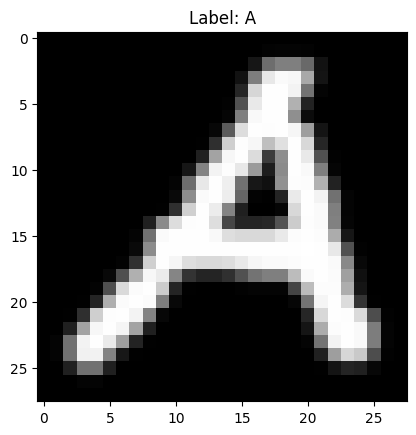

In [188]:
plt.imshow(balanced_train_images[1].reshape(28, 28).T, cmap='gray')
plt.title(f"Label: {chr(balanced_train_labels[1] + 64)}")

In [189]:
unique, counts = np.unique(balanced_train_labels, return_counts=True)
labels_as_letters = [chr(label + 64) for label in unique]
unique

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26], dtype=uint8)

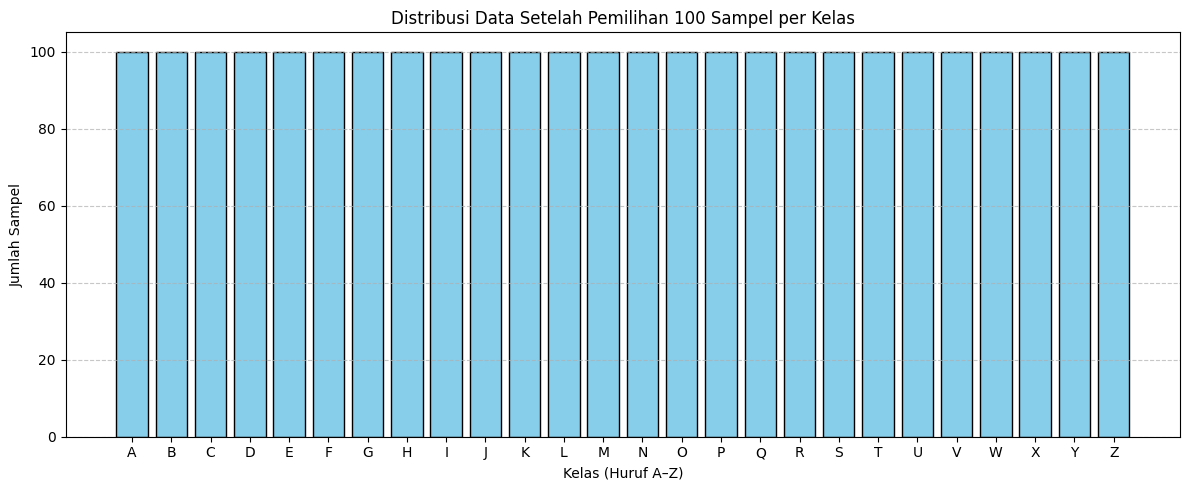

In [190]:
plt.figure(figsize=(12, 5))
plt.bar(labels_as_letters, counts, color='skyblue', edgecolor='black')
plt.title("Distribusi Data Setelah Pemilihan 100 Sampel per Kelas")
plt.xlabel("Kelas (Huruf A–Z)")
plt.ylabel("Jumlah Sampel")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [191]:
shuffle_idx = np.random.permutation(len(balanced_train_labels))
balanced_train_images = balanced_train_images[shuffle_idx]
balanced_train_labels = balanced_train_labels[shuffle_idx]

In [192]:
feature, hog_image = hog(balanced_train_images[0].reshape(28,28), orientations=6, pixels_per_cell=(8, 8), cells_per_block=(2,2), visualize=True, block_norm='L2-Hys')

(96,)

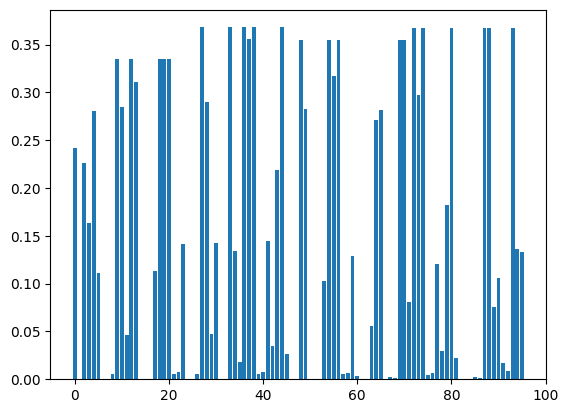

In [193]:
plt.bar(list(range(feature.shape[0])), feature)
feature.shape

In [194]:
n_dims = feature.shape[0]
n_dims

96

In [195]:
n_samples=balanced_train_images.shape[0]
n_samples

2600

In [196]:
#Create Variable Train for dataset
X_train, y_train = datasets.make_classification(n_samples, n_dims)
X_train.shape, y_train.shape

((2600, 96), (2600,))

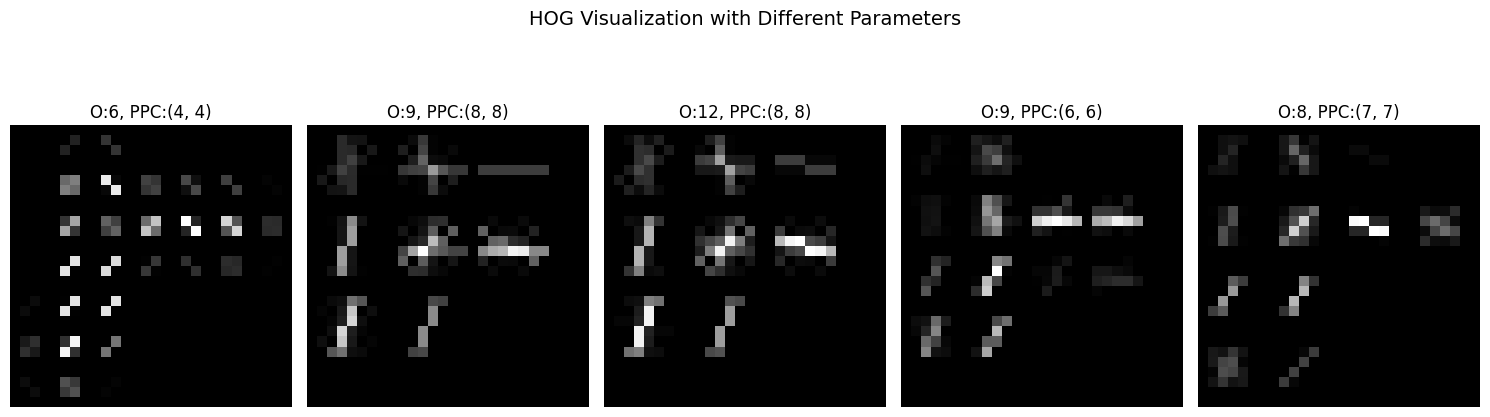

In [197]:
from skimage.feature import hog
import matplotlib.pyplot as plt

# Example image
img = balanced_train_images[1].reshape(28, 28).T

# Different parameter sets to try
param_sets = [
    {"orientations": 6, "pixels_per_cell": (4, 4), "cells_per_block": (2, 2)},
    {"orientations": 9, "pixels_per_cell": (8, 8), "cells_per_block": (2, 2)},
    {"orientations": 12, "pixels_per_cell": (8, 8), "cells_per_block": (3, 3)},
    {"orientations": 9, "pixels_per_cell": (6, 6), "cells_per_block": (2, 2)},
    {"orientations": 8, "pixels_per_cell": (7, 7), "cells_per_block": (2, 2)},
]

plt.figure(figsize=(15, 5))

for i, params in enumerate(param_sets):
    features, hog_image = hog(
        img,
        visualize=True,
        block_norm='L2',
        **params
    )
    
    plt.subplot(1, len(param_sets), i + 1)
    plt.imshow(hog_image, cmap='gray')
    plt.title(f"O:{params['orientations']}, PPC:{params['pixels_per_cell']}")
    plt.axis('off')

plt.suptitle("HOG Visualization with Different Parameters", fontsize=14)
plt.tight_layout()
plt.show()


In [198]:
#For HogFeature train
for i in range(n_samples):
    X_train[i], _ = hog(balanced_train_images[i].reshape(28, 28),orientations=6, pixels_per_cell=(8, 8), cells_per_block=(2,2), visualize=True, block_norm='L2')
    y_train[i] = balanced_train_labels[i]

In [199]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42,shuffle=False)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2080, 96), (2080,), (520, 96), (520,))

# Implement Support Vector Machine

In [200]:
from sklearn.svm import SVC
clf = SVC()


# Use GridSearchCV to find best parameter for SVM

In [201]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, classification_report,confusion_matrix
import pandas as pd


scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro')
}

param_grid = {
    'C': [0.1,1,3.2, 5.0, 2.4, 10.0],
    'kernel': ['rbf', 'linear'],
    'gamma': ["scale", "auto"]
}
grid_search = GridSearchCV(clf, param_grid, scoring=scoring, cv=5, refit='f1', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)


cv_results = pd.DataFrame(grid_search.cv_results_)
cv_metrics = cv_results[['params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1']]
print("\n=== Hasil Evaluasi Training (Cross-Validation) ===")
print(cv_metrics.sort_values(by='mean_test_f1', ascending=False))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/home/dika/miniconda3/envs/MachineLearning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dika/miniconda3/envs/MachineLearning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dika/miniconda3/envs/MachineLearning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif


=== Hasil Evaluasi Training (Cross-Validation) ===
                                               params  mean_test_accuracy  \
20     {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}            0.779808   
16      {'C': 2.4, 'gamma': 'scale', 'kernel': 'rbf'}            0.775962   
12      {'C': 5.0, 'gamma': 'scale', 'kernel': 'rbf'}            0.775000   
8       {'C': 3.2, 'gamma': 'scale', 'kernel': 'rbf'}            0.773558   
4         {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}            0.760577   
11    {'C': 3.2, 'gamma': 'auto', 'kernel': 'linear'}            0.758654   
9    {'C': 3.2, 'gamma': 'scale', 'kernel': 'linear'}            0.758654   
19    {'C': 2.4, 'gamma': 'auto', 'kernel': 'linear'}            0.754327   
17   {'C': 2.4, 'gamma': 'scale', 'kernel': 'linear'}            0.754327   
21  {'C': 10.0, 'gamma': 'scale', 'kernel': 'linear'}            0.750000   
23   {'C': 10.0, 'gamma': 'auto', 'kernel': 'linear'}            0.750000   
13   {'C': 5.0, 'gamma':

In [202]:
best_model = grid_search.best_estimator_
print("\n=== Parameter Terbaik ===")
print(grid_search.best_params_)


=== Parameter Terbaik ===
{'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}


# Use Leave-One-Out-Cross-Validation Evaluation

In [203]:
from sklearn.model_selection import LeaveOneOut, cross_val_predict
loo = LeaveOneOut()
y_pred_loocv = cross_val_predict(best_model, X_train, y_train, cv=loo)
accuracy = accuracy_score(y_train, y_pred_loocv)
print("LOOCV Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision_score(y_train, y_pred_loocv, average='weighted') * 100))
print("Recall: {:.2f}%".format(recall_score(y_train, y_pred_loocv, average='weighted')))
print("F1 Score: {:.2f}%".format(f1_score(y_train, y_pred_loocv, average='weighted')))

cof_LOOCV = confusion_matrix(y_train, y_pred_loocv)

LOOCV Accuracy: 79.38%
Precision: 79.58%
Recall: 0.79%
F1 Score: 0.79%


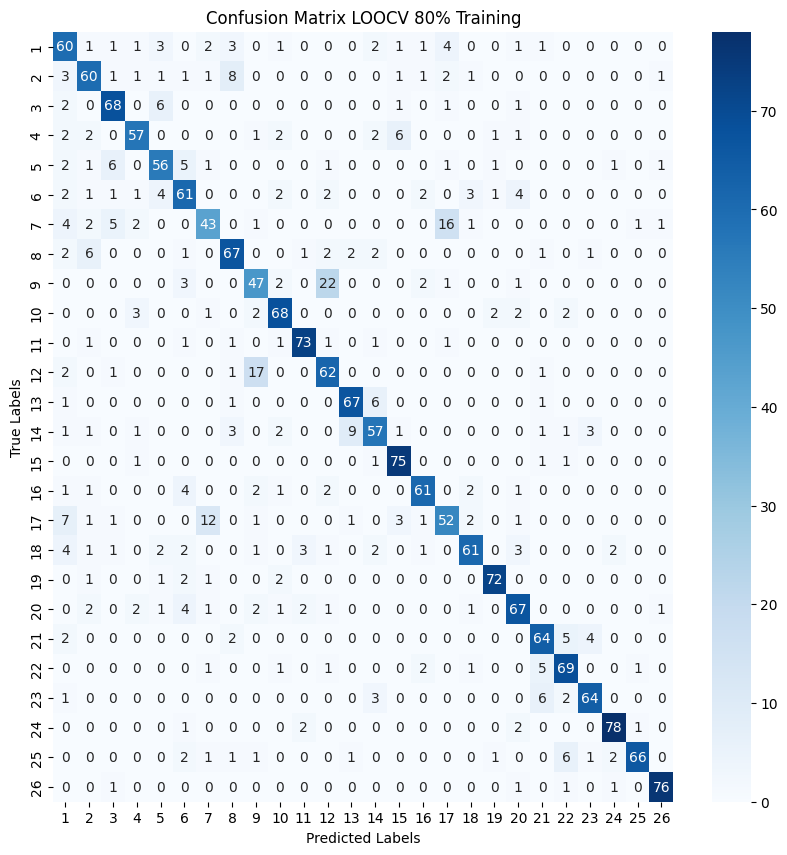

In [204]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(cof_LOOCV, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix LOOCV 80% Training")
plt.show()

# Use 20% from dataset to Evaluation

In [205]:
pred_test = best_model.predict(X_test) 
print("Test Accuracy: {:.2f}%".format(accuracy_score(y_test, pred_test) * 100))
print("Test Precision: {:.2f}".format(precision_score(y_test, pred_test, average='macro')))
print("Test Recall: {:.2f}".format(recall_score(y_test, pred_test, average='weighted')))
print("Test F1 Score: {:.2f}".format(f1_score(y_test, pred_test, average='weighted')))
conf_mat = confusion_matrix(y_test, pred_test)


Test Accuracy: 78.27%
Test Precision: 0.79
Test Recall: 0.78
Test F1 Score: 0.78


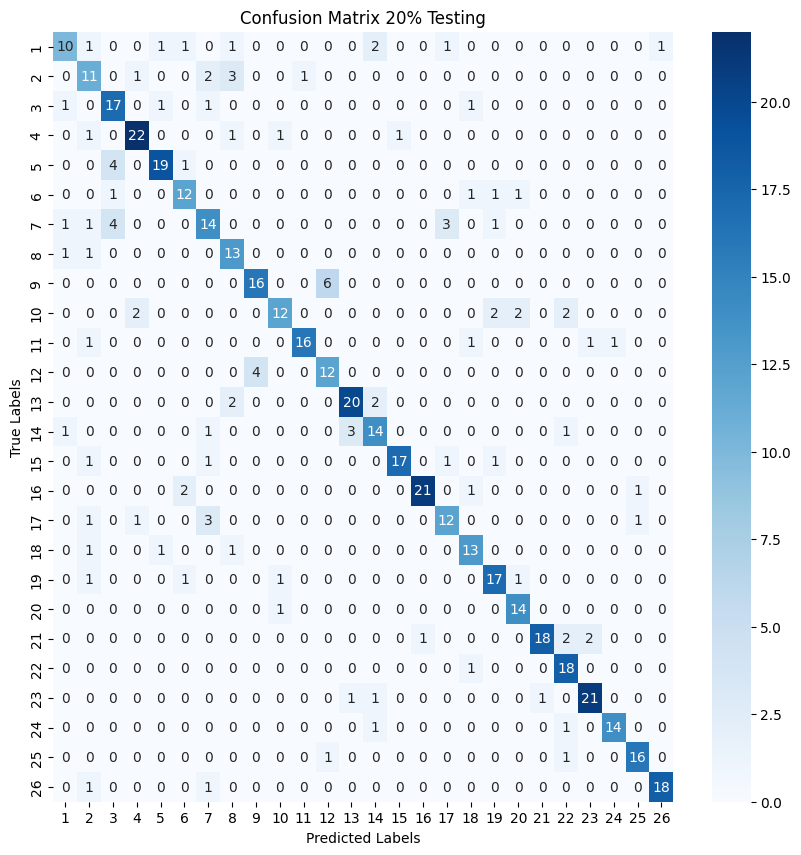

In [206]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix 20% Testing")
plt.show()

# Testing Model

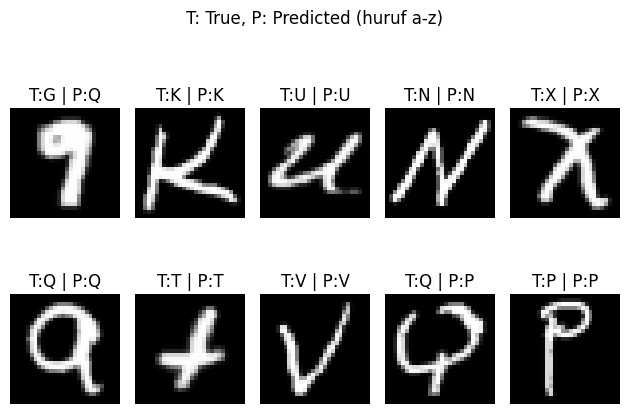

In [ ]:
import matplotlib.pyplot as plt
import random
indices = random.sample(range(len(X_train)), 10)
for i, idx in enumerate(indices):
    img =  balanced_train_images[idx].reshape(28, 28).T
    # img = X_test[i]
    true_label = y_train[idx] 
    pred_label = y_pred_loocv[idx] 

    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"T:{chr(true_label + 64)} | P:{chr(pred_label + 64)}") 
    plt.axis('off')
plt.suptitle("T: True, P: Predicted (huruf a-z)")
plt.tight_layout()
plt.show()

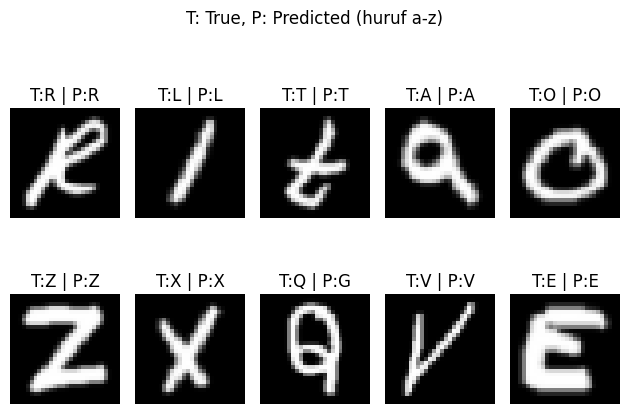

In [208]:
indices = random.sample(range(len(X_test)), 10)

for i, idx in enumerate(indices):
    img =  balanced_train_images[idx+2080].reshape(28, 28).T
    # img = X_test[i]
    true_label = y_test[idx] 
    pred_label = pred_test[idx] 

    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"T:{chr(true_label + 64)} | P:{chr(pred_label + 64)}") 
    plt.axis('off')

plt.suptitle("T: True, P: Predicted (huruf a-z)")
plt.tight_layout()
plt.show()